Импортируем необходимые библиотеки

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture



Загружаем датасет как в примере

In [226]:
dataset = pd.read_csv('data/session_task_dataset.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))

In [227]:
dataset.shape

(23479, 500)

In [228]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


Покажем больше сигналов, чтобы наглядно видеть аномалии и выбросы.

Text(0, 0.5, 'bit ADC')

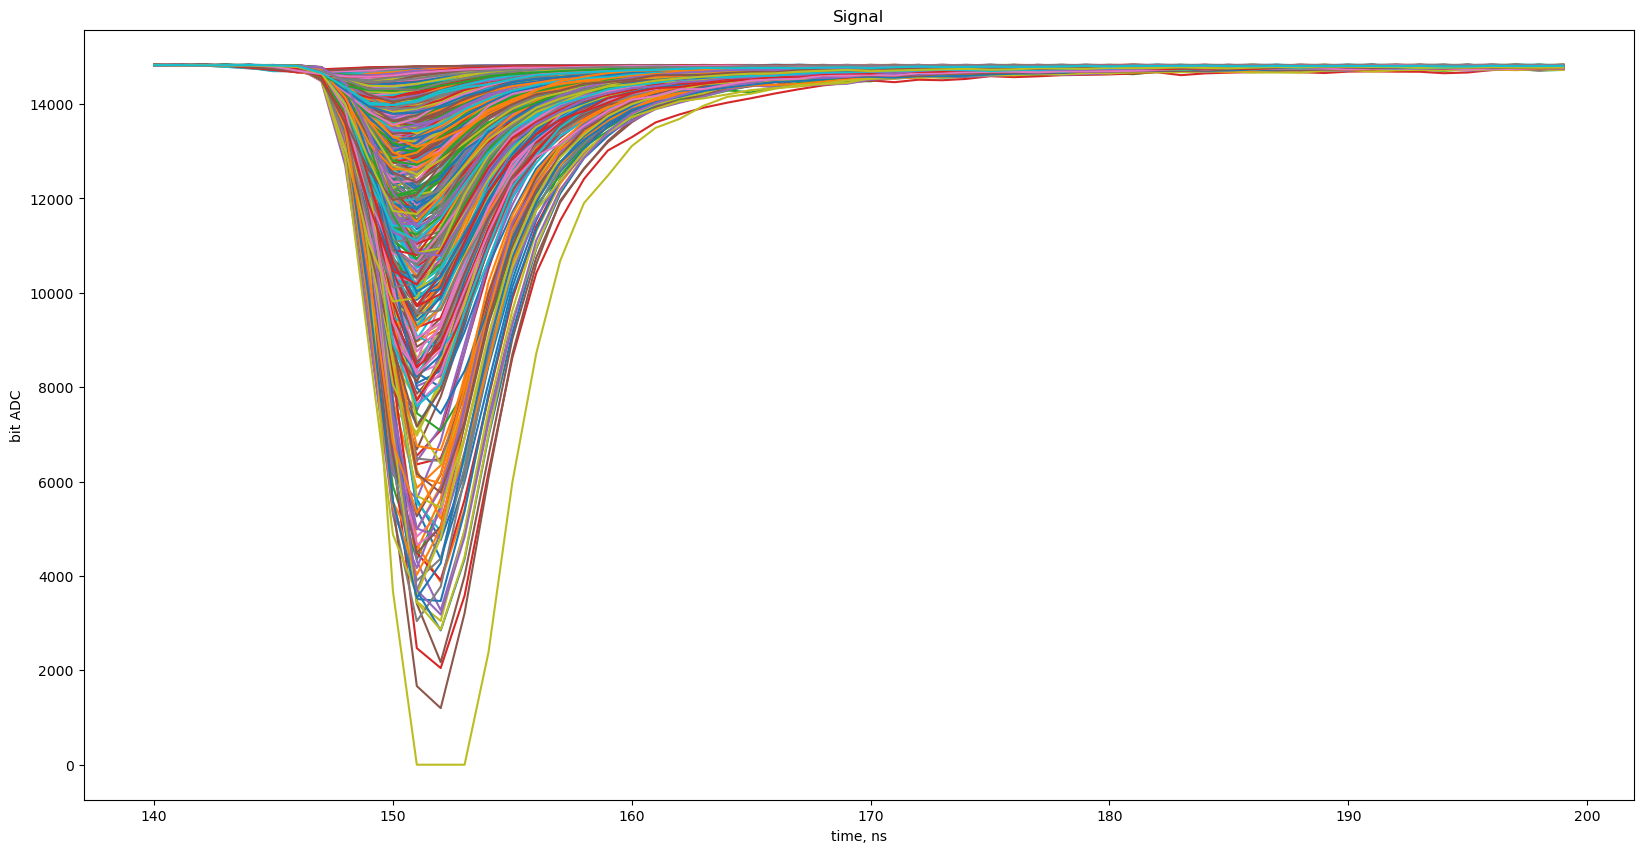

In [229]:
N=range(1000)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Видим ряд сигналов, которые ведут себя не так как остальные. Например видим "пологую" амплитуду сигнала. Такие сигналы абсолютно точно не поддаются кластеризации и попадают в остаточный кластер 2.

Инвертируем датасет для удобства дальнейшей работы.

In [230]:
df_inv = 2**14 - dataset
df_inv.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1564,1561,1560,1562,1566,1564,1560,1562,1564,1564,...,1556,1562,1569,1569,1567,1565,1564,1562,1564,1565
1,1564,1562,1564,1558,1560,1562,1564,1562,1561,1563,...,1556,1567,1560,1562,1560,1565,1564,1565,1562,1564
2,1564,1564,1562,1559,1564,1560,1560,1565,1561,1560,...,1564,1563,1564,1564,1566,1563,1561,1564,1564,1563
3,1556,1562,1566,1560,1560,1562,1564,1562,1560,1564,...,1560,1558,1562,1563,1564,1556,1564,1562,1561,1562
4,1561,1569,1561,1563,1557,1564,1561,1560,1568,1563,...,1564,1564,1561,1556,1560,1564,1560,1560,1562,1559


Text(0, 0.5, 'bit ADC')

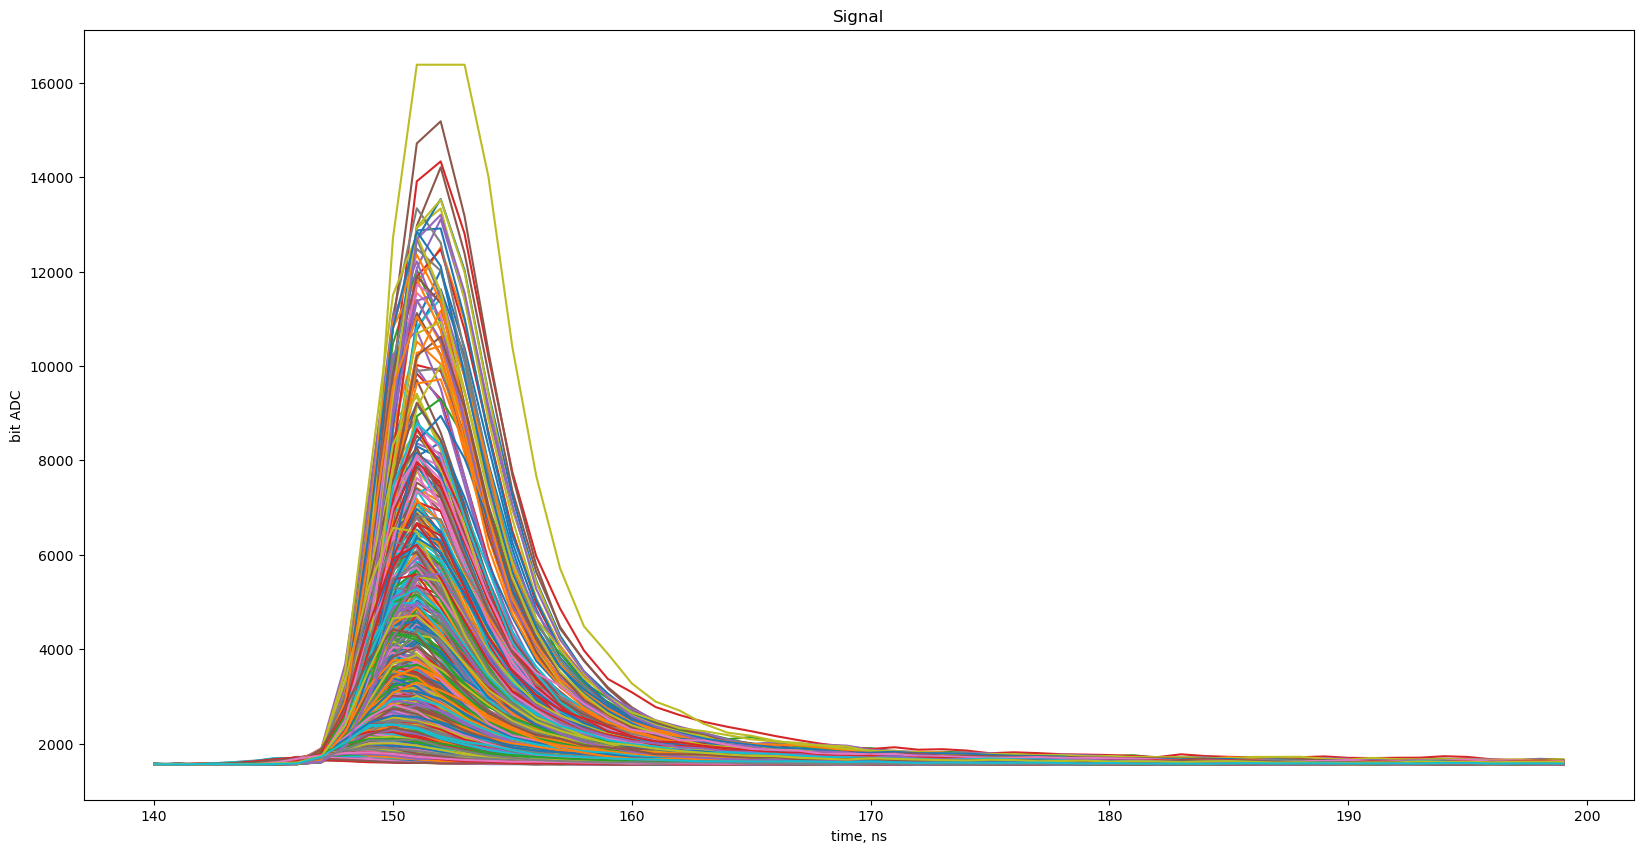

In [231]:
N=range(1000)
ax = df_inv.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Для начала выделим сигналы согласно п. 2.1. методического материала по формуле:
𝑆𝑖𝑔𝑛𝑎𝑙𝑗 = 𝑅𝑎𝑤 𝐷𝑎𝑡𝑎𝑗 [𝑖𝑚𝑎𝑥 ; 𝑖𝑚𝑗+3𝜎𝑗 ]. А также сами параметры, которые позволяют определить кривую сигнала: его начало, его пик, его окончание. Также выделим среди признаком его амлитуду и площадь под кривой сигнала.

In [232]:
def extract_signal(df_inv: pd.DataFrame,
                   pre_window: int = 140,
                   sigma_level: float = 3) -> pd.DataFrame:
    results = []

    for _, row in df_inv.iterrows():
        trace = row.to_numpy(dtype=float)

        # baseline и сигма по первым pre_window точкам
        baseline = np.median(trace[:pre_window])
        noise_std = np.std(trace[:pre_window], ddof=1)

        # максимум
        i_max = int(np.argmax(trace))
        i_start = min(i_max, len(trace) - 1)
        peak_value = trace[i_max]

        # конец сигнала
        threshold = baseline + sigma_level * noise_std
        below = np.where(trace[i_start:] <= threshold)[0]
        i_end = i_start + (below[0] if below.size else len(trace) - 1)

        # вырезаем импульс, вычитаем baseline
        sig_slice = trace[i_start : i_end + 1] - baseline

        # если импульс «вниз» — разворачиваем
        if sig_slice[0] < 0:
            sig_slice = -sig_slice

        # амплитуда и площадь
        amp  = sig_slice[0]                       
        area = np.trapz(sig_slice, dx=1.0)        

        results.append({
            "start"      : i_start,
            "peak_value" : peak_value,
            "end"        : i_end,
            "signal"     : sig_slice,             
            "amp"        : amp,
            "area"       : area,
            "baseline"   : baseline
        })

    return pd.DataFrame(results, index=df_inv.index)

signals_df = extract_signal(df_inv)

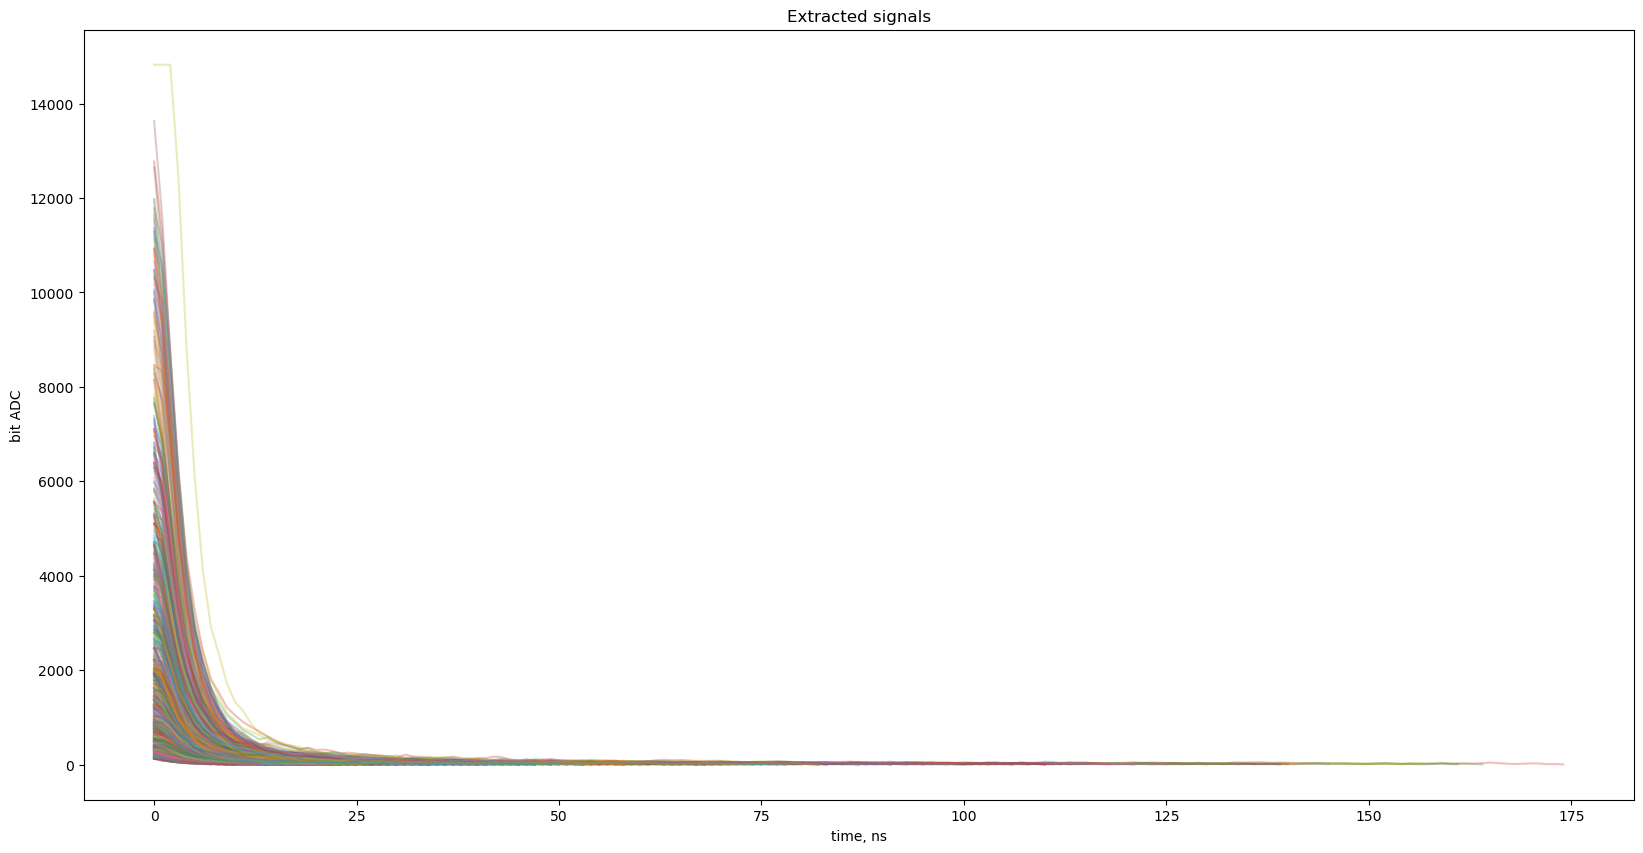

In [233]:
N = range(1000)                          
fig, ax = plt.subplots(figsize=(20, 10))

for idx in N:
    sig = signals_df.at[idx, 'signal']  
    ax.plot(np.arange(len(sig)), sig, alpha=0.3)

ax.set_title('Extracted signals')
ax.set_xlabel('time, ns')
ax.set_ylabel('bit ADC')
plt.show()

Согласно информации из методических материалов, сигналом в контексте поставленной задачи следует назвать подмножество значений кривой, содержащееся между максимумом и местом, где значение кривой начало отставать от нулевой линии на три стандартных отклонения. 
Учитывая то что мы видим на графике и изложенное выше, мы верно выделили сигналы.

In [234]:
signals_df

,start,peak_value,end,signal,amp,area,baseline
0,149,2093.0,173,"[529.0, 442.0, 360.0, 288.0, 213.0, 190.0, 139...",529.0,2552.5,1564.0
1,150,3463.0,188,"[1901.5, 1783.5, 1434.5, 1070.5, 766.5, 549.5,...",1901.5,8490.5,1561.5
2,151,4120.0,187,"[2558.0, 2042.0, 1498.0, 1063.0, 720.0, 530.0,...",2558.0,9256.5,1562.0
3,149,2126.0,182,"[565.0, 526.0, 463.0, 344.0, 249.0, 187.0, 155...",565.0,3099.0,1561.0
4,150,3356.0,180,"[1793.0, 1627.0, 1323.0, 946.0, 660.0, 465.0, ...",1793.0,7677.0,1563.0
...,...,...,...,...,...,...,...
23474,149,2064.0,169,"[504.0, 491.0, 420.0, 252.0, 202.0, 177.0, 132...",504.0,2295.0,1560.0
23475,151,7327.0,250,"[5766.0, 5665.0, 4554.0, 3430.0, 2521.0, 1840....",5766.0,32732.0,1561.0
23476,151,6559.0,278,"[4998.0, 4539.0, 3551.0, 2644.0, 1887.0, 1423....",4998.0,27968.0,1561.0
23477,150,3017.0,205,"[1456.0, 1339.0, 1043.0, 783.0, 595.0, 464.0, ...",1456.0,8144.5,1561.0


Таким образом, мы получили ряд признаком для дальнейшей кластеризации.

Масштабируем данные для дальнейшей кластеризации.

In [235]:
scaler = StandardScaler()
X = scaler.fit_transform(np.vstack((signals_df["area"], signals_df["amp"])).T)

Используем метод главных компонент (PCA). Это позволяет алгоритму кластеризации (GMM) разделить сигналы быстрее, точнее и стабильнее.

In [236]:
pca = PCA(n_components=1)
principal_component = pca.fit_transform(X)

После снижения размерности с помощью PCA, у нас есть одномерное распределение сигналов.

 Кластеризация на основе одной главной компоненты (разделение на два типа сигналов + прочие).

In [237]:
gmm = GaussianMixture(n_components=3, random_state=0)
clusters = gmm.fit_predict(principal_component)

Стандартная оценка качества кластеризации. Используем те же метрики, что и в методических материалах.

In [238]:
silhouette = silhouette_score(principal_component, clusters)
calinski_harabasz = calinski_harabasz_score(principal_component, clusters)
print(f'Silhouette Score: {silhouette:.4f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.4f}')

Silhouette Score: 0.5632
Calinski-Harabasz Score: 43795.5527


Silhouette Score выше 0.5 что говорит об успешной кластеризации.
Calinski-Harabasz Score также имеет очень высокий показатель, что говорит о хорошем разделении сигналов.

визуально отобоазим как разбились сигналы в пространстве.

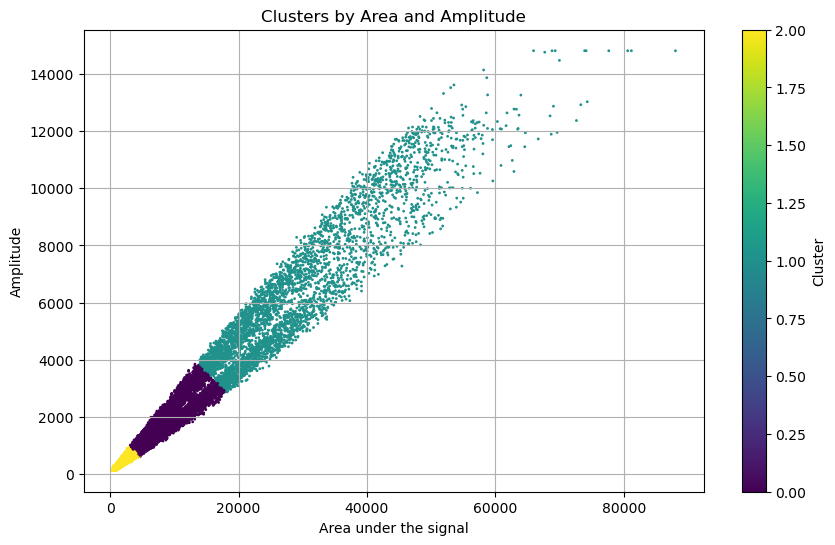

In [239]:
plt.figure(figsize=(10,6))
plt.scatter(signals_df["area"], signals_df["amp"], c=clusters, cmap='viridis', s=1)
plt.xlabel('Area under the signal')
plt.ylabel('Amplitude')
plt.title('Clusters by Area and Amplitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

На графике мы видим, что алгоритм кластеризации GMM по факту не справился с задачей, так как, исходя из методических материалов, у нейтронных событий характерное время высвечивания больше, следовательно, сигнал "растянут", а площадь под кривой больше относительно амплитуды.

У гамма-квантов время высвечивания меньше и площадь под кривой ближе к амплитуде.

Следовательно, нейтроны выше по площади при одинаковой амплитуде, а гамма-кванты ниже по площади при одинаковой амплитуде.

Но видим, что алгоритм кластеризации GMM разделил сигналы поверхностями равных вероятностей, обычно это представляют на плоскости как овал или размытую границу.

Еще раз посмотрим на сигналы в разрезе отношения амплитуды и площади.

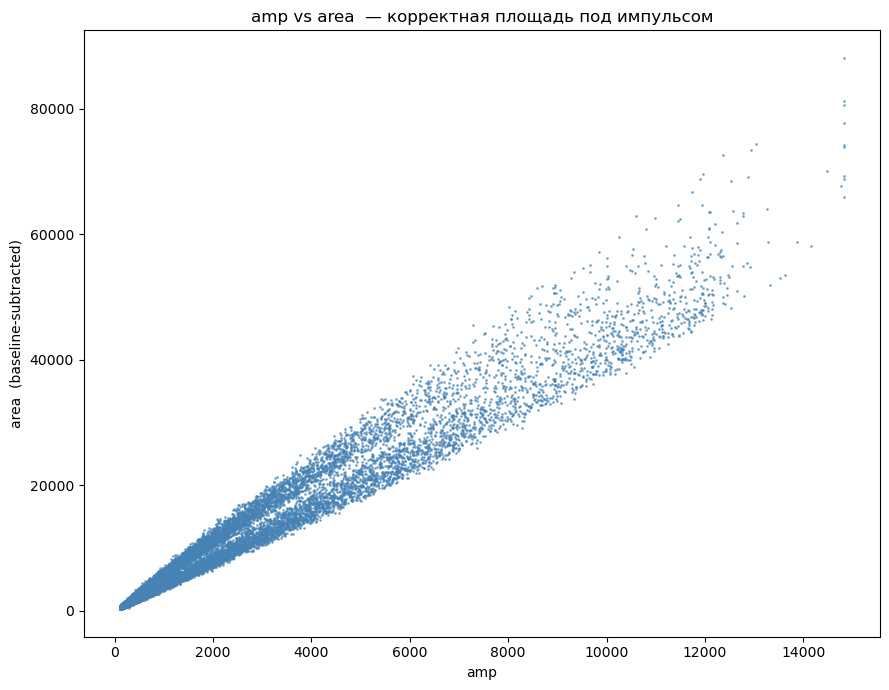

In [240]:
plt.figure(figsize=(9, 7))
plt.scatter(signals_df["amp"], signals_df["area"],
            s=1, alpha=0.6, color="steelblue")
plt.xlabel("amp")
plt.ylabel("area  (baseline-subtracted)")
plt.title("amp vs area  — корректная площадь под импульсом")
plt.tight_layout()
plt.show()

добавим в датасет отношение площади к амплитуде для каждого сигнала.

In [241]:
signals_df["ratio"] = signals_df["area"] / signals_df["amp"]
signals_df

,start,peak_value,end,signal,amp,area,baseline,ratio
0,149,2093.0,173,"[529.0, 442.0, 360.0, 288.0, 213.0, 190.0, 139...",529.0,2552.5,1564.0,4.825142
1,150,3463.0,188,"[1901.5, 1783.5, 1434.5, 1070.5, 766.5, 549.5,...",1901.5,8490.5,1561.5,4.465159
2,151,4120.0,187,"[2558.0, 2042.0, 1498.0, 1063.0, 720.0, 530.0,...",2558.0,9256.5,1562.0,3.618647
3,149,2126.0,182,"[565.0, 526.0, 463.0, 344.0, 249.0, 187.0, 155...",565.0,3099.0,1561.0,5.484956
4,150,3356.0,180,"[1793.0, 1627.0, 1323.0, 946.0, 660.0, 465.0, ...",1793.0,7677.0,1563.0,4.281651
...,...,...,...,...,...,...,...,...
23474,149,2064.0,169,"[504.0, 491.0, 420.0, 252.0, 202.0, 177.0, 132...",504.0,2295.0,1560.0,4.553571
23475,151,7327.0,250,"[5766.0, 5665.0, 4554.0, 3430.0, 2521.0, 1840....",5766.0,32732.0,1561.0,5.676726
23476,151,6559.0,278,"[4998.0, 4539.0, 3551.0, 2644.0, 1887.0, 1423....",4998.0,27968.0,1561.0,5.595838
23477,150,3017.0,205,"[1456.0, 1339.0, 1043.0, 783.0, 595.0, 464.0, ...",1456.0,8144.5,1561.0,5.593750


Строим гладкую аппроксимацию плотности вероятности для признака area/amp.
из методических материов значеи, что метод KDE (Kernel Density Estimation) позволяет получить гладкую кривую вместо рваной гистограммы. Параметр bw_method подобран эмпирически.

In [242]:
ratios = signals_df["ratio"].values
kde = gaussian_kde(ratios, bw_method=0.06)
r_ax = np.linspace(ratios.min(), ratios.max(), 1200)
pdf = kde(r_ax)


Находим все локальные максимумы (пики) на графике плотности pdf и из всех найденных пиков выбираем два самых высоких. Затем находим точки минимума между двумя пиками.

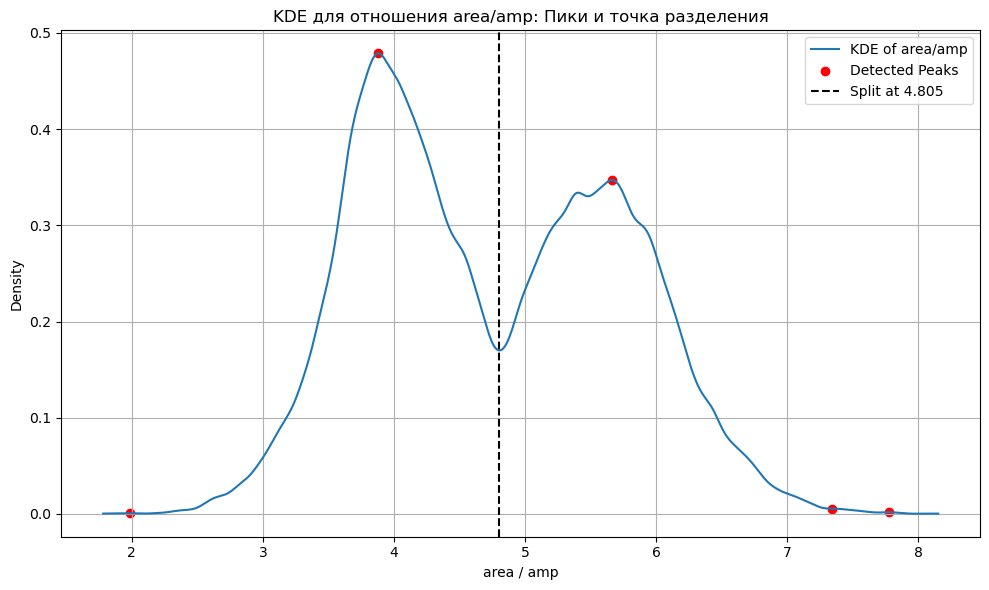

In [243]:
pk_idx, _ = find_peaks(pdf, distance=80)
pks = pk_idx[np.argsort(pdf[pk_idx])[-2:]]
pks.sort()
valley_rel = np.argmin(pdf[pks[0]:pks[1]])
k_split = r_ax[pks[0] + valley_rel]

# Визуализация
plt.figure(figsize=(10,6))
plt.plot(r_ax, pdf, label='KDE of area/amp')
plt.scatter(r_ax[pk_idx], pdf[pk_idx], color='red', label='Detected Peaks')
plt.axvline(k_split, color='black', linestyle='--', label=f'Split at {k_split:.3f}')
plt.xlabel('area / amp')
plt.ylabel('Density')
plt.title('KDE для отношения area/amp: Пики и точка разделения')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

График подтверждает, что сигналы естественным образом делятся на два физических типа, и оптимальная граница разделения найдена корректно.

Далее сформируем условия (маски) для разделения сигналов на кластеры:
- Если area у сигнала меньше чем k_split * amp, то это гамма-квант (кластер 0)
- Всё, что не gamma, считается нейтроном (кластер 1)
- Если амплитуда очень маленькая (amp < 200), то это шум (кластер 2)

In [244]:
mask_gamma = signals_df["area"] <= k_split * signals_df["amp"]
mask_neutron = ~mask_gamma
mask_noise = signals_df["amp"] < 200

Присваиваем метки по маскам

In [245]:
signals_df.loc[mask_gamma, "cluster"] = 0
signals_df.loc[mask_neutron, "cluster"] = 1
signals_df.loc[mask_noise, "cluster"] = 2
signals_df["cluster"] = signals_df["cluster"].astype(int)

визуализируем распределение меток (без шума) для показательности

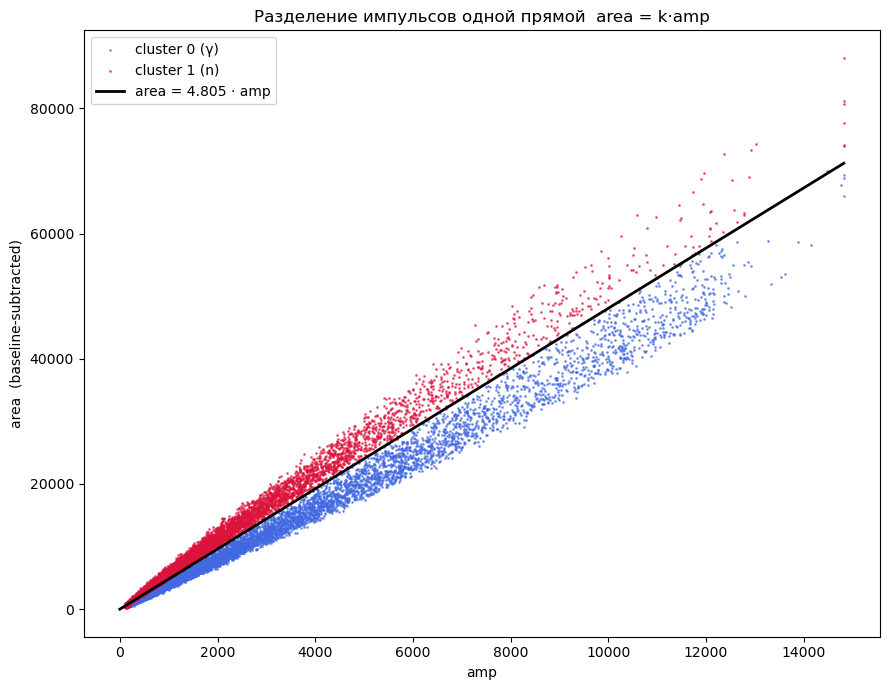

In [246]:
plt.figure(figsize=(9, 7))

# γ-импульсы (cluster 0)
mask = signals_df["cluster"] == 0
plt.scatter(signals_df.loc[mask, "amp"],
            signals_df.loc[mask, "area"],
            s=1, alpha=0.6, color="royalblue", label="cluster 0 (γ)")

# нейтроны  (cluster 1)
mask = ~mask
plt.scatter(signals_df.loc[mask, "amp"],
            signals_df.loc[mask, "area"],
            s=1, alpha=0.6, color="crimson",  label="cluster 1 (n)")

# разделяющая прямая
x_line = np.linspace(0, signals_df["amp"].max(), 400)
plt.plot(x_line, k_split * x_line, color="black",
         lw=2, label=f"area = {k_split:.3f} · amp")

plt.xlabel("amp")
plt.ylabel("area  (baseline-subtracted)")
plt.title("Разделение импульсов одной прямой  area = k·amp")
plt.legend()
plt.tight_layout()
plt.show()

Видим, что кластеры распределились согласно их физическому смыслу.

Оформляем решение в конечный csv с сортировкой кластеров.

In [247]:
out = pd.DataFrame({
    "index": signals_df.index,     
    "cluster": signals_df["cluster"].astype(int)
}, index=None)
out
def reset_clusters_indexes(result_df):
    clusters_relation = {}
    current_cluster = 0

    def define_new_cluster(cluster):
        nonlocal current_cluster
        if clusters_relation.get(cluster) is None:
            clusters_relation[cluster] = current_cluster
            current_cluster += 1
        return clusters_relation[cluster]

    result_df['cluster'] = result_df['cluster'].apply(lambda x: define_new_cluster(x))
    return result_df
out = reset_clusters_indexes(out)
out.to_csv('sub.csv', index=False)

Скриншот с Kaggle

![image_copy.png](image_copy.png)